# 5b. Gene Expression Violin Plots

Violin plots (size=0, mean±SEM diamonds) for NANOG and SOX21,
across H1 differentiation (Fig 1) and Ctrl vs JARID2 (Fig 2).

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib.offsetbox import TextArea, HPacker, AnchoredOffsetbox

/scratch/users/chensj16/venvs/dl2025/.venv/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Load data

In [2]:
adata_merged = sc.read_h5ad('adata_merged.250505-canonical.h5ad')

In [3]:
# Figure 1 samples (H1 differentiation series)
sample_sel1 = adata_merged.obs['sample'].isin(
    ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T', 'H1-E', 'H1-ET', 'H1-E4T.1']
)
adata1 = adata_merged[sample_sel1].copy()

# Figure 2 samples (Ctrl vs JARID2)
sample_sel2 = adata_merged.obs['sample'].isin(
    ['Ctrl-hPSC.p1', 'Ctrl-E.p6', 'Ctrl-ET.p1', 'H1-E4T.3',
     'JARID2-hPSC', 'JARID2-E', 'JARID2-ET', 'JARID2-E4T']
)
adata2 = adata_merged[sample_sel2].copy()

## Color & label definitions

In [4]:
# Figure 1 color setup
H1_color_lut = {
    'H1-hPSC.p6' : '#f6c445',
    'H1-0.5E'    : '#47aa43',
    'H1-0.5ET'   : '#72a699',
    'H1-0.5E4T'  : '#65dcee',
    'H1-E'       : '#36753b',
    'H1-ET'      : '#3c69c3',
    'H1-E4T.1'   : '#2e247e',
}
sample_order_1 = ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T',
                   'H1-E', 'H1-ET', 'H1-E4T.1']

# Figure 2 color setup
legend_lut = {
    'Ctrl-hPSC.p1' : 'hPSC',
    'JARID2-hPSC'  : 'hPSC',
    'Ctrl-E.p6'    : 'Ectoderm',
    'JARID2-E'     : 'Ectoderm',
    'Ctrl-ET.p1'   : '24 h ectoderm\n\u2192 1 day of mTeSR',
    'JARID2-ET'    : '24 h ectoderm\n\u2192 1 day of mTeSR',
    'H1-E4T.3'     : '24 h ectoderm\n\u2192 4 days of mTeSR',
    'JARID2-E4T'   : '24 h ectoderm\n\u2192 4 days of mTeSR'
}

ctrl_samples = ['Ctrl-hPSC.p1', 'Ctrl-E.p6', 'Ctrl-ET.p1', 'H1-E4T.3']
jarid2_samples = ['JARID2-hPSC', 'JARID2-E', 'JARID2-ET', 'JARID2-E4T']

ctrl_cond_colors = {
    'hPSC': '#f6c445',
    'Ectoderm': '#72a699',
    '24 h ectoderm\n\u2192 1 day of mTeSR': '#3c69c3',
    '24 h ectoderm\n\u2192 4 days of mTeSR': '#2e247e'
}

jarid2_cond_colors = {
    'hPSC': '#CE8E1B',
    'Ectoderm': '#477343',
    '24 h ectoderm\n\u2192 1 day of mTeSR': '#a1c8e7',
    '24 h ectoderm\n\u2192 4 days of mTeSR': '#78599d'
}

sample_order_2 = ['Ctrl-hPSC.p1', 'JARID2-hPSC',
                  'Ctrl-E.p6', 'JARID2-E',
                  'Ctrl-ET.p1', 'JARID2-ET',
                  'H1-E4T.3', 'JARID2-E4T']

sample_palette_2 = {}
for s in ctrl_samples:
    sample_palette_2[s] = ctrl_cond_colors[legend_lut[s]]
for s in jarid2_samples:
    sample_palette_2[s] = jarid2_cond_colors[legend_lut[s]]

## Helper: violin plot functions

In [5]:
def plot_violin_fig1(gene, adata, sample_order, color_lut, save_path,
                     show_nonzero_mean=False):
    """Violin plot for H1 differentiation series (Figure 1)."""
    WIDTH_PER_VIOLIN = 1.1
    fig_w = WIDTH_PER_VIOLIN * len(sample_order)

    all_df = pd.DataFrame({
        gene: np.asarray(adata[:, gene].X.toarray()).flatten(),
        'Sample': adata.obs['sample'].values,
    })

    fig, ax = plt.subplots(figsize=(fig_w, 6))

    sns.violinplot(data=all_df, x='Sample', y=gene,
                   order=sample_order, palette=color_lut,
                   ax=ax, linewidth=0.3, inner=None, density_norm='count',
                   saturation=1, cut=0)

    ax.yaxis.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
    ax.set_axisbelow(True)

    for i, sample in enumerate(sample_order):
        vals = all_df.loc[all_df['Sample'] == sample, gene]
        ax.errorbar(i, vals.mean(), yerr=vals.sem(),
                    fmt='D', color='red', markersize=4,
                    ecolor='darkred', elinewidth=1, capsize=3, capthick=0.8, zorder=5)
        if show_nonzero_mean:
            nz = vals[vals > 0]
            if len(nz) > 0:
                ax.errorbar(i, nz.mean(), yerr=nz.sem(),
                            fmt='D', markerfacecolor='none', markeredgecolor='red',
                            markersize=4, ecolor='red', elinewidth=1,
                            capsize=3, capthick=0.8, zorder=5)

    ax.set_title(f'H1 Differentiation \u2014 $\\it{{{gene}}}$', fontsize=16, fontweight='bold')

    tick_labels = []
    for s in sample_order:
        vals = all_df.loc[all_df['Sample'] == s, gene]
        tick_labels.append(
            f"{s}\n"
            f"mean\u00b1SEM:\n"
            f"\u03bc={vals.mean():.2f}\u00b1{vals.sem():.2f}"
        )
    ax.set_xticks(range(len(sample_order)))
    ax.set_xticklabels(tick_labels, rotation=90, ha='right', fontsize=9)
    ax.set_xlabel('')
    ax.set_ylabel(f'$\\it{{{gene}}}$', fontsize=14)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'Saved: {save_path}')
    plt.show()


def plot_violin_fig2(gene, adata, sample_order, sample_palette, legend_lut,
                     jarid2_samples, save_path, show_nonzero_mean=False):
    """Violin plot for Ctrl vs JARID2 interleaved (Figure 2)."""
    jarid2_set = set(jarid2_samples)
    WIDTH_PER_VIOLIN = 1.1
    fig_w = WIDTH_PER_VIOLIN * len(sample_order)

    all_df = pd.DataFrame({
        gene: np.asarray(adata[:, gene].X.toarray()).flatten(),
        'Sample': adata.obs['sample'].values,
    })

    fig, ax = plt.subplots(figsize=(fig_w, 6))

    sns.violinplot(data=all_df, x='Sample', y=gene,
                   order=sample_order, palette=sample_palette,
                   ax=ax, linewidth=0.3, inner=None, density_norm='count',
                   saturation=1, cut=0)

    ax.yaxis.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
    ax.set_axisbelow(True)

    for i, sample in enumerate(sample_order):
        vals = all_df.loc[all_df['Sample'] == sample, gene]
        ax.errorbar(i, vals.mean(), yerr=vals.sem(),
                    fmt='D', color='red', markersize=4,
                    ecolor='darkred', elinewidth=1, capsize=3, capthick=0.8, zorder=5)
        if show_nonzero_mean:
            nz = vals[vals > 0]
            if len(nz) > 0:
                ax.errorbar(i, nz.mean(), yerr=nz.sem(),
                            fmt='D', markerfacecolor='none', markeredgecolor='red',
                            markersize=4, ecolor='red', elinewidth=1,
                            capsize=3, capthick=0.8, zorder=5)

    for sep_x in [1.5, 3.5, 5.5]:
        ax.axvline(sep_x, color='gray', linewidth=0.5, linestyle='--')

    # Title: "Control vs JARID2-CRISPRi — {gene}"
    t_ctrl = TextArea("Control vs ", textprops=dict(color="black", fontsize=16, fontweight='bold'))
    t_j1 = TextArea("JARID2", textprops=dict(color="red", fontstyle="italic",
                    fontsize=16, fontweight='bold'))
    t_j2 = TextArea("-CRISPRi \u2014 ", textprops=dict(color="black", fontsize=16, fontweight='bold'))
    t_gene = TextArea(f"{gene}", textprops=dict(color="black", fontsize=16,
                      fontweight='bold', fontstyle='italic'))
    title_box = HPacker(children=[t_ctrl, t_j1, t_j2, t_gene], pad=0, sep=0)
    anchored_title = AnchoredOffsetbox(loc='lower center', child=title_box,
                                        pad=0, frameon=False,
                                        bbox_to_anchor=(0.5, 1.02),
                                        bbox_transform=ax.transAxes)
    ax.add_artist(anchored_title)

    tick_labels = []
    for s in sample_order:
        vals = all_df.loc[all_df['Sample'] == s, gene]
        cond = legend_lut[s].replace('\n', ' ')
        tick_labels.append(
            f"{cond}\n({s})\n"
            f"mean\u00b1SEM:\n"
            f"\u03bc={vals.mean():.2f}\u00b1{vals.sem():.2f}"
        )
    ax.set_xticks(range(len(sample_order)))
    ax.set_xticklabels(tick_labels, rotation=90, ha='right', fontsize=9)

    for i, label in enumerate(ax.get_xticklabels()):
        if sample_order[i] in jarid2_set:
            label.set_color('red')

    ax.set_xlabel('')
    ax.set_ylabel(f'$\\it{{{gene}}}$', fontsize=14)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'Saved: {save_path}')
    plt.show()

# Figure 1

## NANOG violin

/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.NANOG.violin.pdf


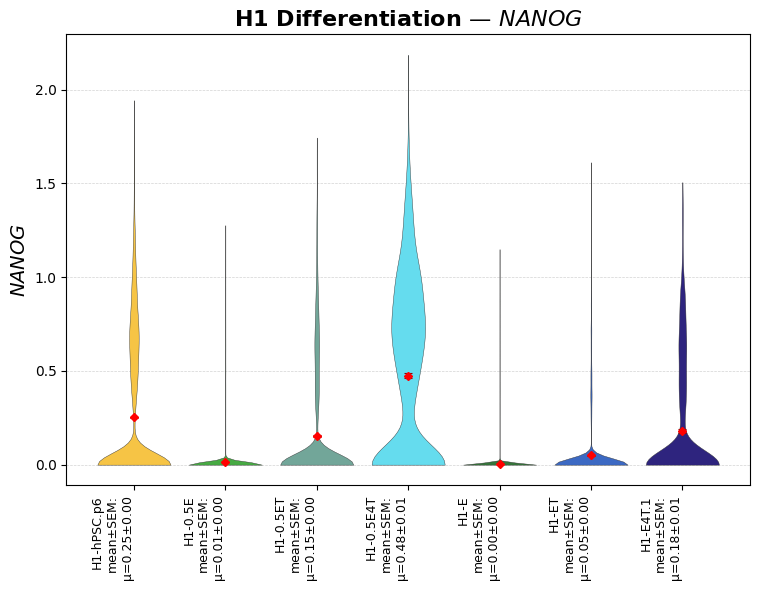

In [6]:
plot_violin_fig1('NANOG', adata1, sample_order_1, H1_color_lut,
                 'figures/Figure1.NANOG.violin.pdf')

## SOX21 violin

/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.SOX21.violin.pdf


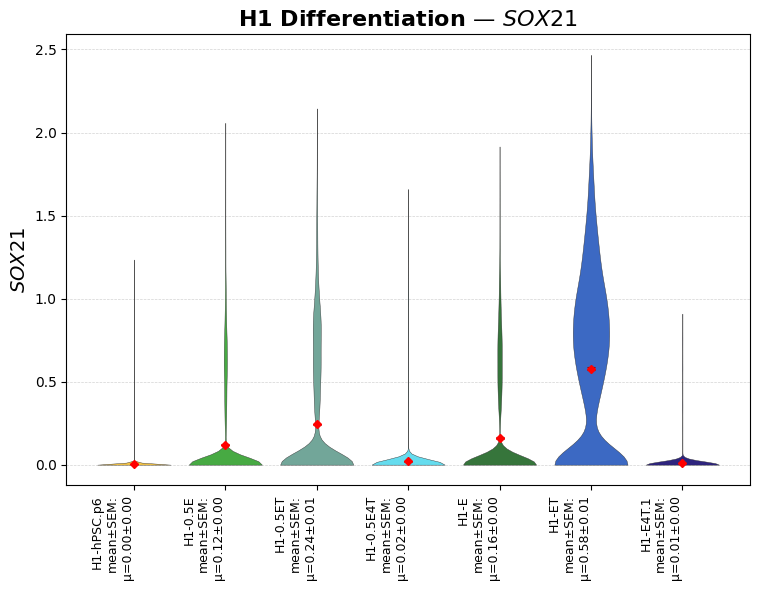

In [7]:
plot_violin_fig1('SOX21', adata1, sample_order_1, H1_color_lut,
                 'figures/Figure1.SOX21.violin.pdf')

## other genes violin

/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.OTX2.violin.pdf


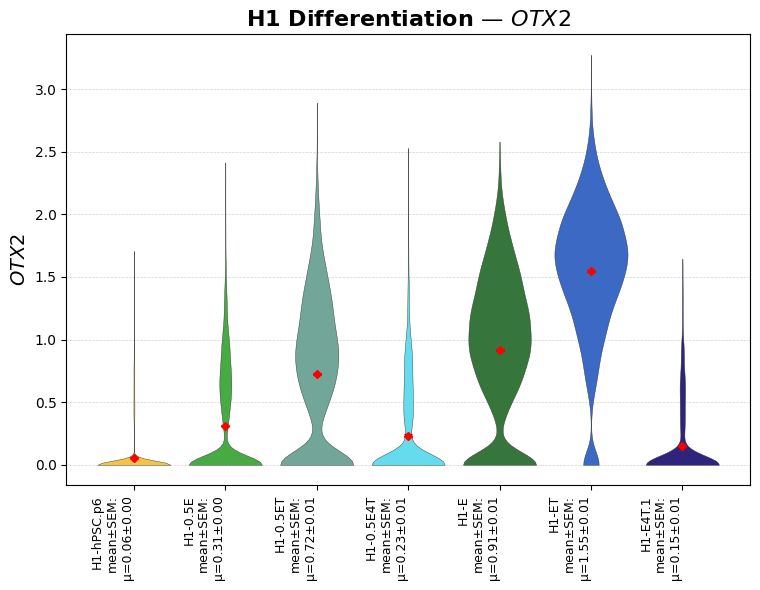

OTX2 violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.ZIC1.violin.pdf


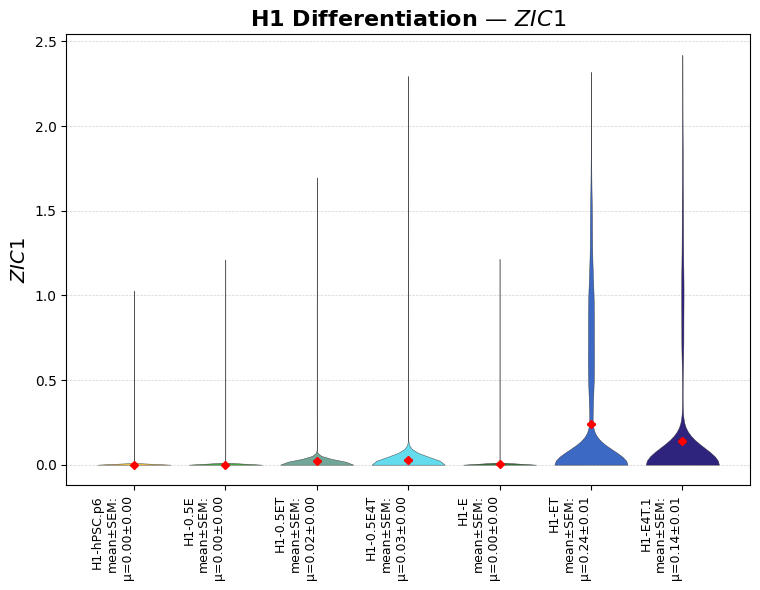

ZIC1 violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.NES.violin.pdf


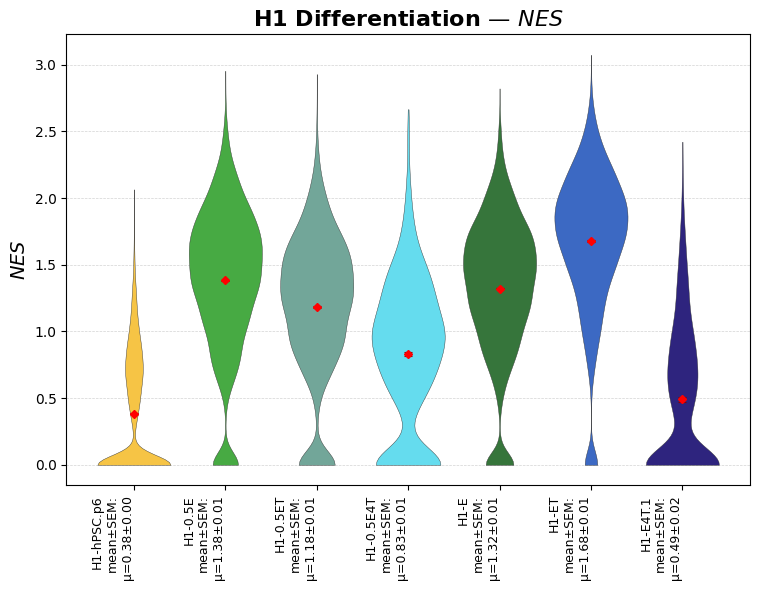

NES violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.SOX1.violin.pdf


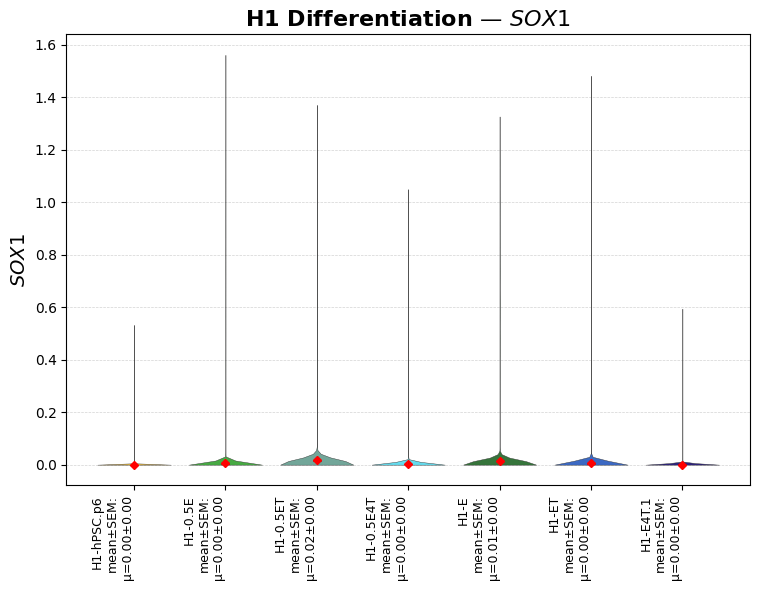

SOX1 violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.MAP2.violin.pdf


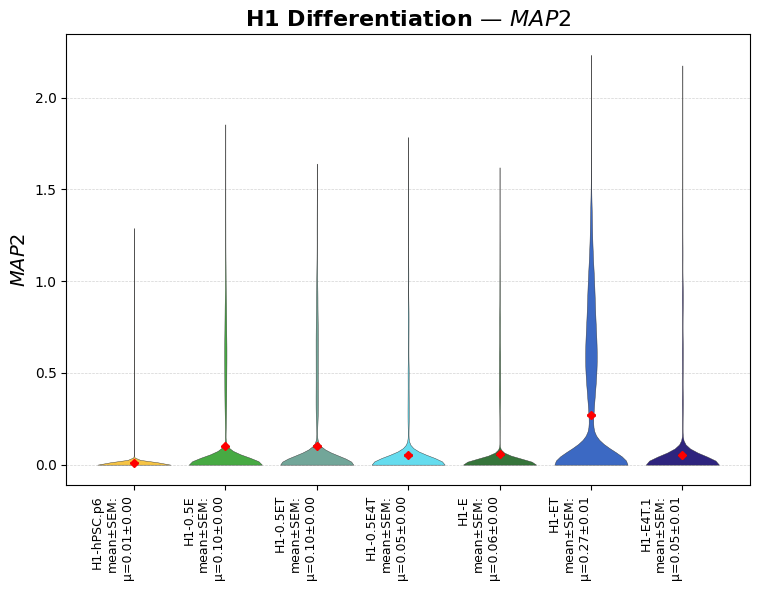

MAP2 violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.COL2A1.violin.pdf


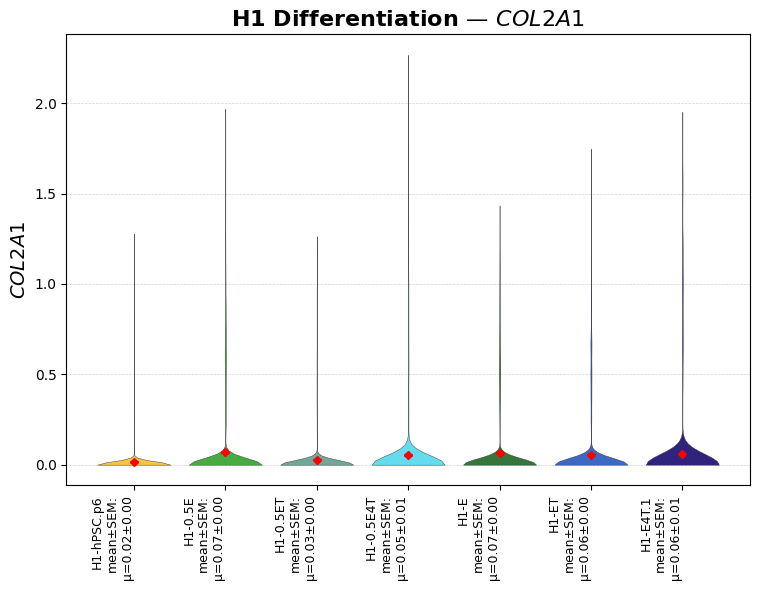

COL2A1 violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.TFAP2C.violin.pdf


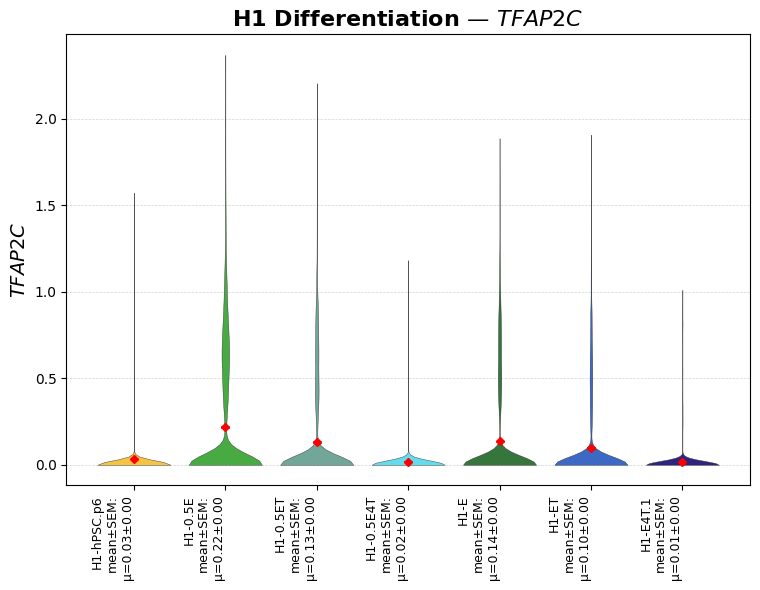

TFAP2C violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.CDH11.violin.pdf


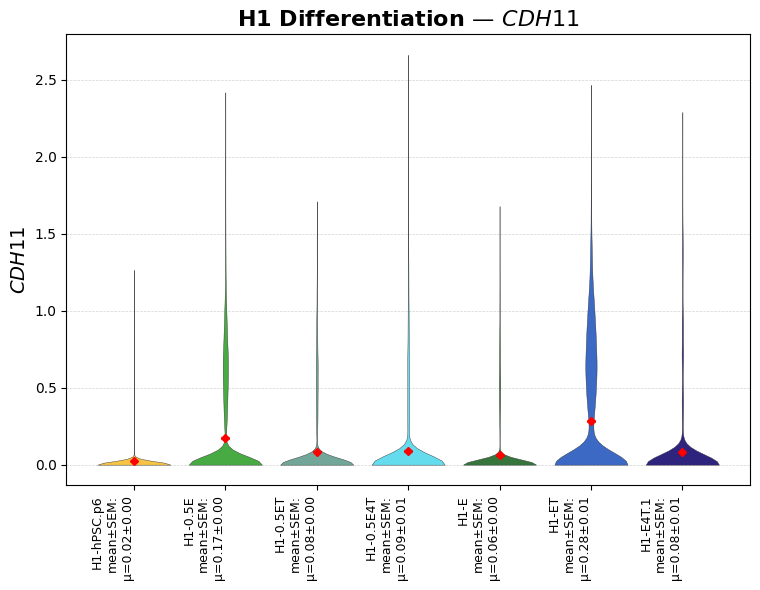

CDH11 violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.FOSL1.violin.pdf


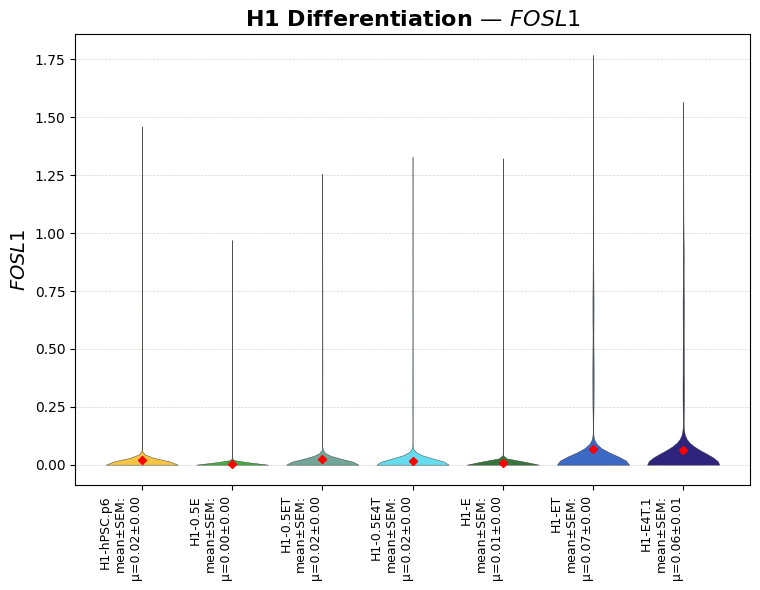

FOSL1 violin drawn


/tmp/ipykernel_3867/2388950861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure1.NFATC4.violin.pdf


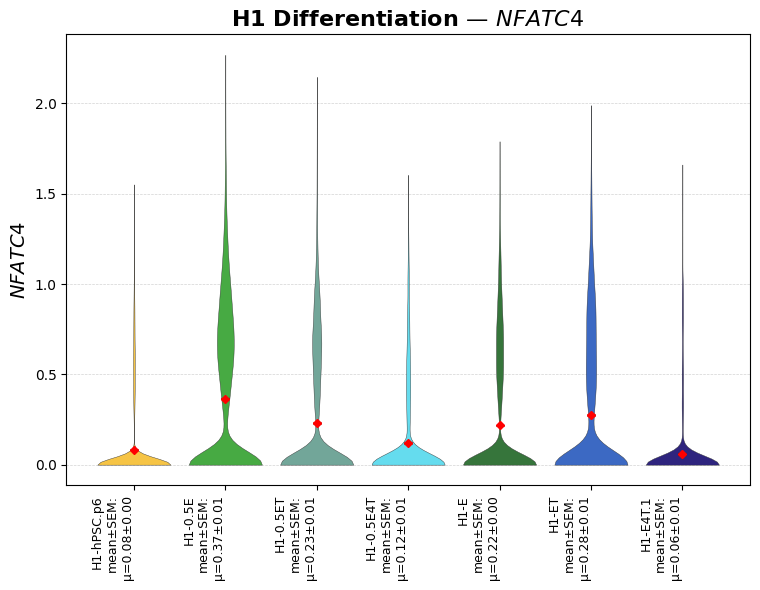

NFATC4 violin drawn


In [24]:
for g in ["OTX2","ZIC1","NES","SOX1","MAP2","COL2A1","TFAP2C","CDH11","FOSL1","NFATC4"]:
    assert g in adata1.var_names.to_list(), f"{g} not found"
    plot_violin_fig1(g, adata1, sample_order_1, H1_color_lut,
                 f'figures/Figure1.{g}.violin.pdf')
    print(f'{g} violin drawn')

# Figure 2 

## NANOG violin

/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.NANOG.violin.pdf


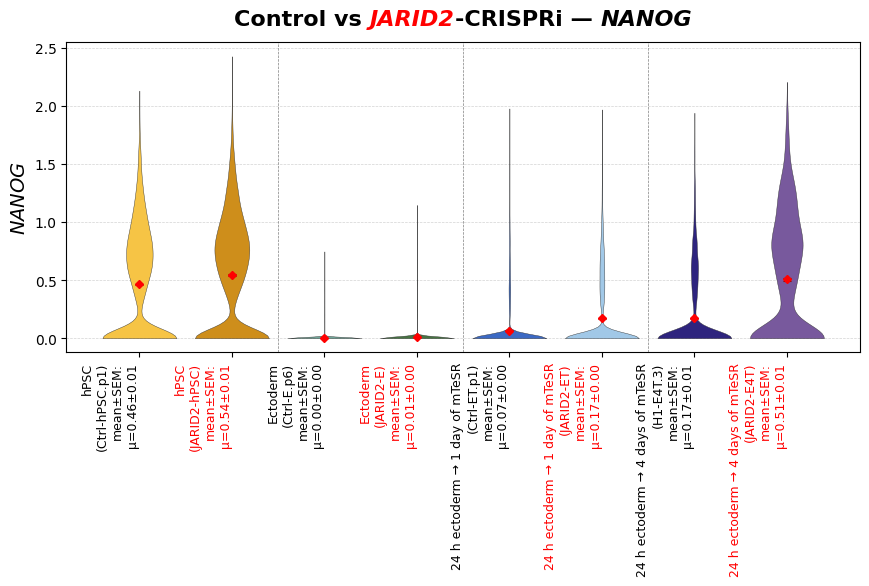

In [8]:
plot_violin_fig2('NANOG', adata2, sample_order_2, sample_palette_2,
                 legend_lut, jarid2_samples,
                 'figures/Figure2.NANOG.violin.pdf')

## SOX21 violin

/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.SOX21.violin.pdf


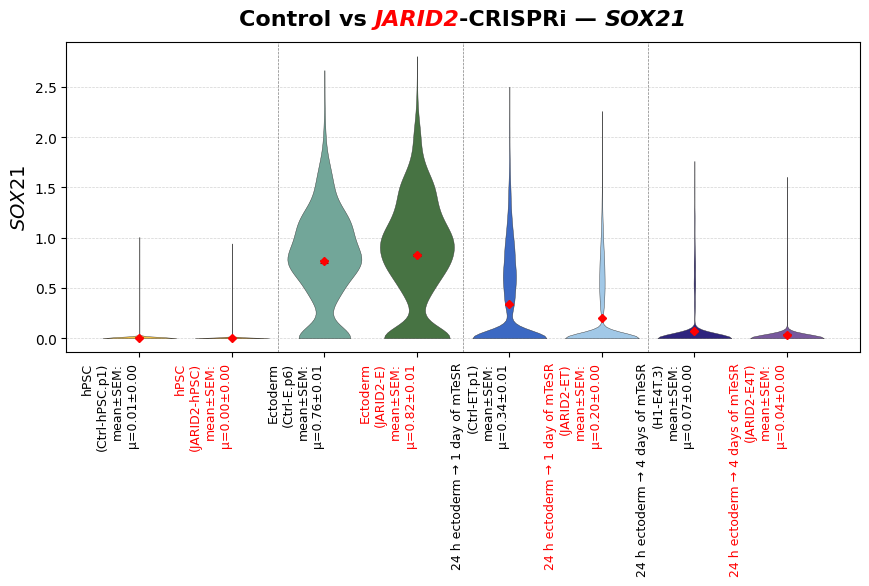

In [9]:
plot_violin_fig2('SOX21', adata2, sample_order_2, sample_palette_2,
                 legend_lut, jarid2_samples,
                 'figures/Figure2.SOX21.violin.pdf')

## other genes violin

/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.OTX2.violin.pdf


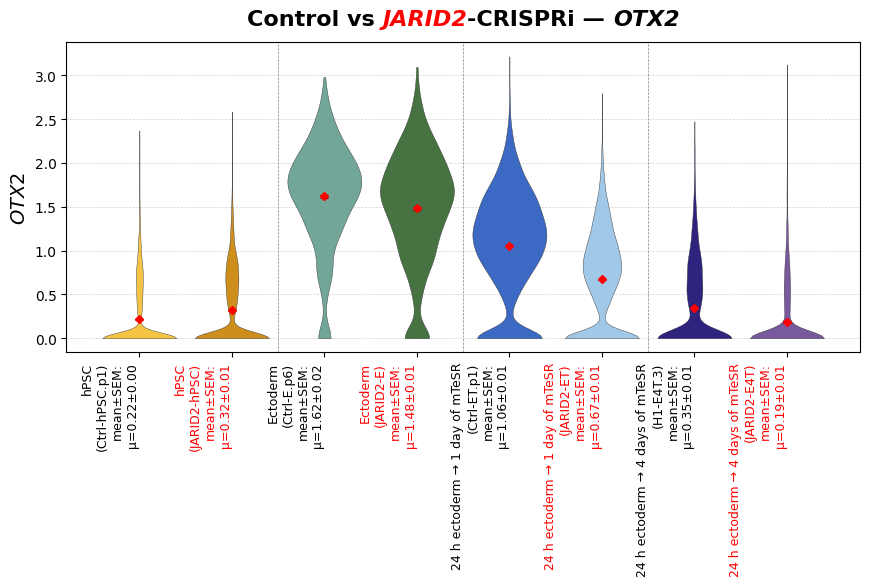

OTX2 violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.ZIC1.violin.pdf


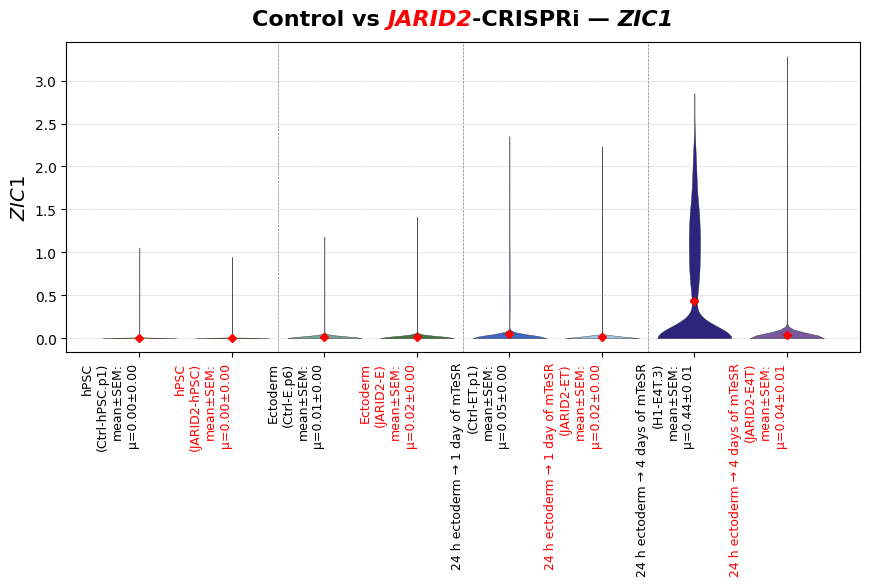

ZIC1 violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.NES.violin.pdf


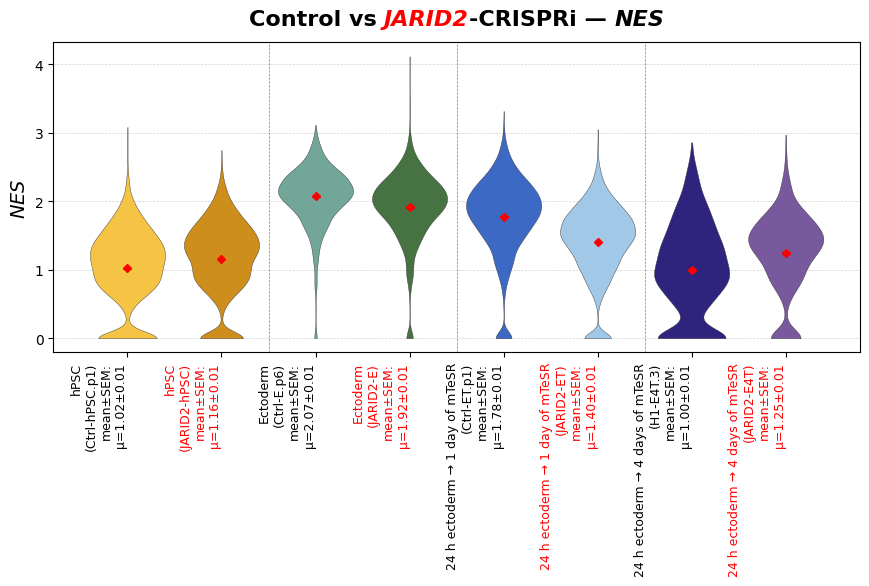

NES violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.SOX1.violin.pdf


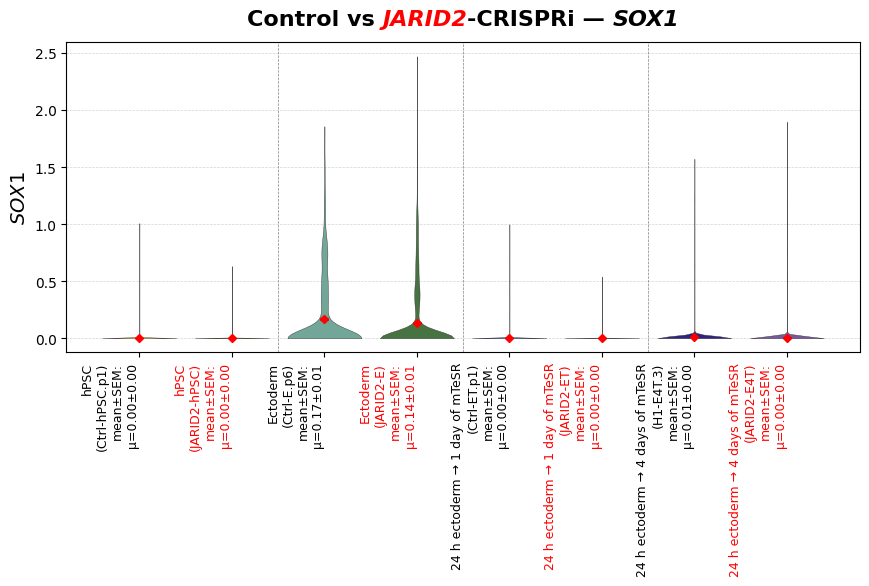

SOX1 violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.MAP2.violin.pdf


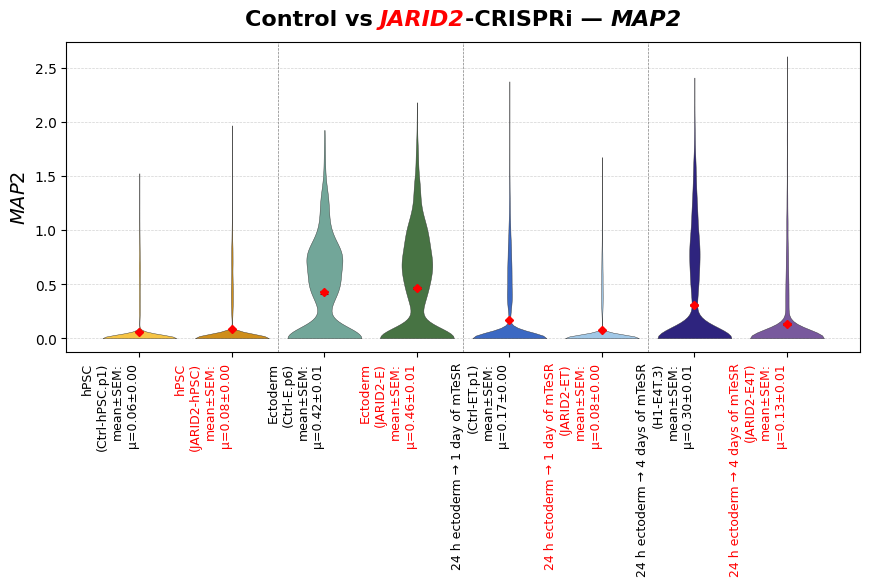

MAP2 violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.COL2A1.violin.pdf


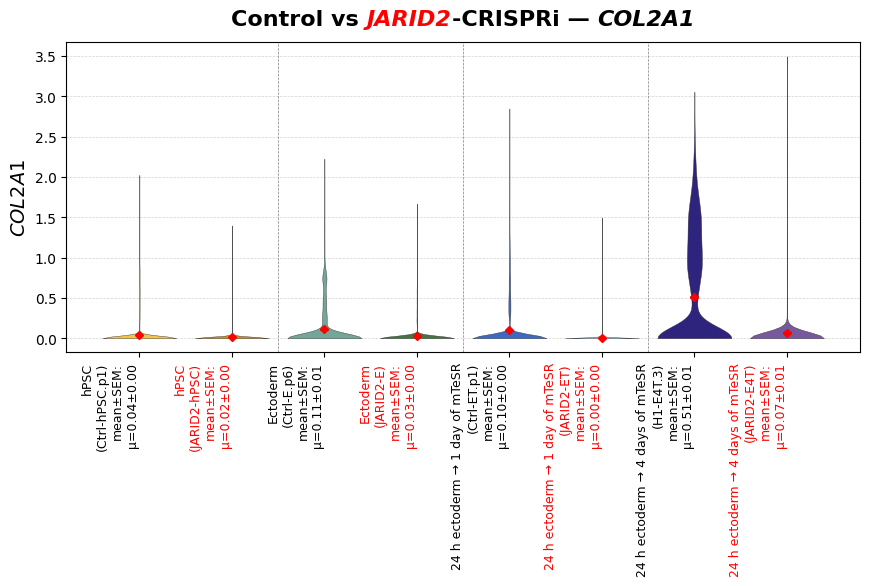

COL2A1 violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.TFAP2C.violin.pdf


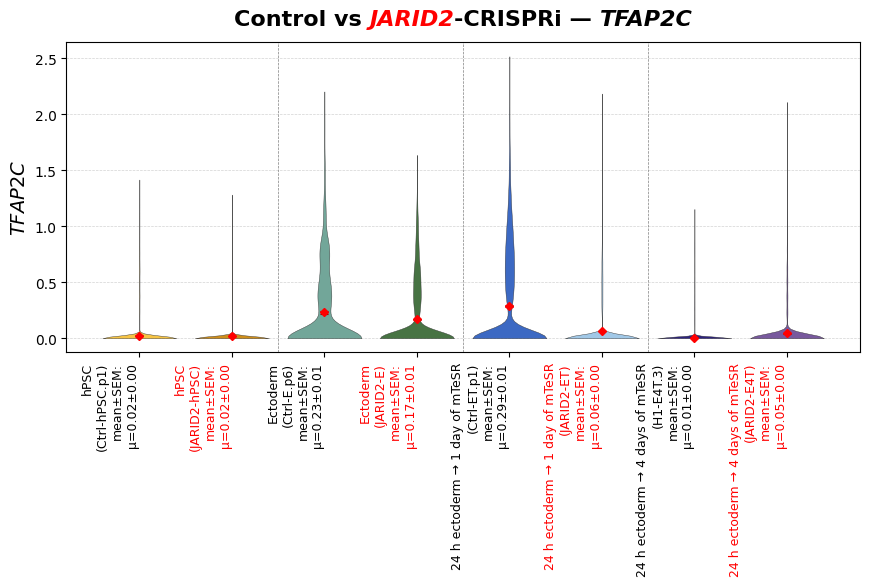

TFAP2C violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.CDH11.violin.pdf


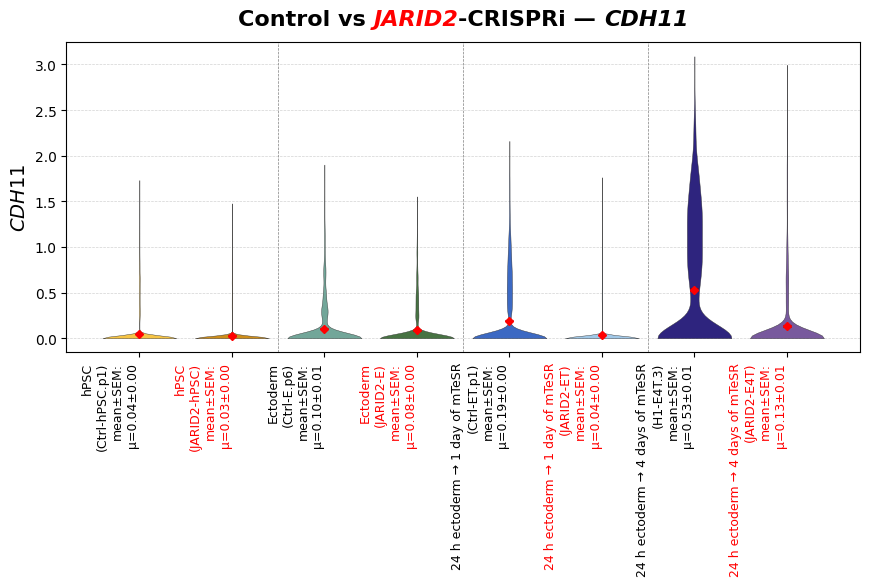

CDH11 violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.FOSL1.violin.pdf


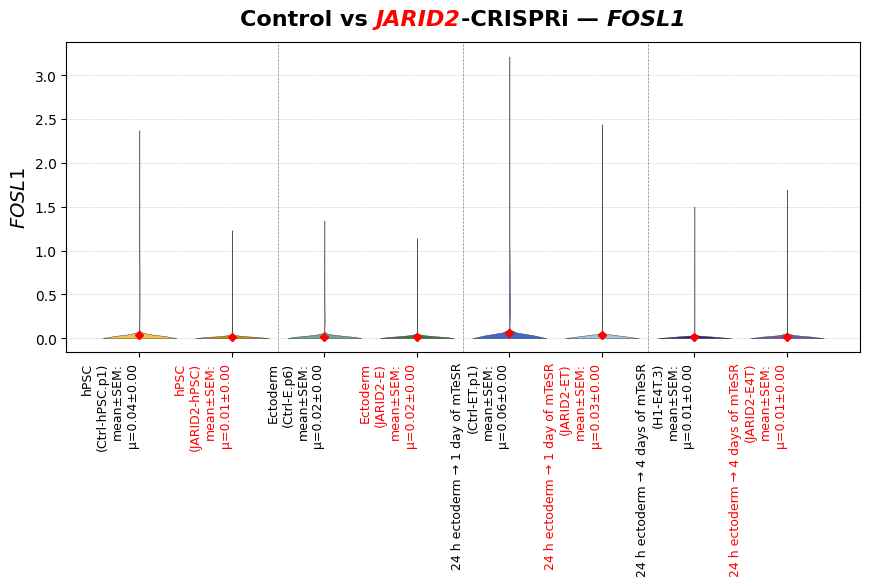

FOSL1 violin drawn


/tmp/ipykernel_3867/2388950861.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


Saved: figures/Figure2.NFATC4.violin.pdf


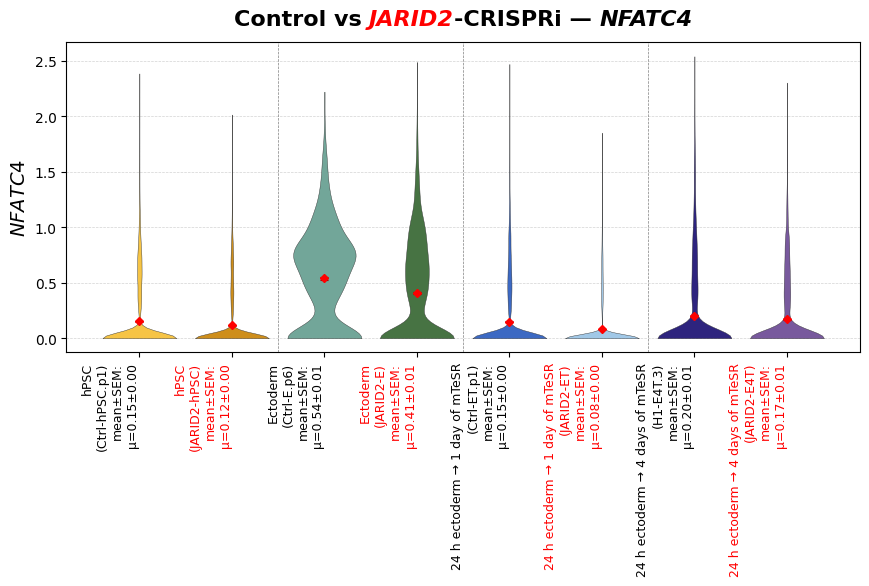

NFATC4 violin drawn


In [27]:
for g in ["OTX2","ZIC1","NES","SOX1","MAP2","COL2A1","TFAP2C","CDH11","FOSL1","NFATC4"]:
    assert g in adata2.var_names.to_list(), f"{g} not found"
    
    plot_violin_fig2(g, adata2, sample_order_2, sample_palette_2,
                 legend_lut, jarid2_samples,
                 f'figures/Figure2.{g}.violin.pdf')
    print(f'{g} violin drawn')